In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('hh_ru_dataset.csv')

# Обработка пустых значений

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   topic_id                 500000 non-null  object 
 1   topic_creation_date      500000 non-null  object 
 2   initial_state            499166 non-null  object 
 3   final_state              499166 non-null  object 
 4   resume_id                500000 non-null  object 
 5   resume_creation_date     500000 non-null  object 
 6   profession               500000 non-null  object 
 7   gender                   500000 non-null  object 
 8   year_of_birth            500000 non-null  int64  
 9   resume_region            500000 non-null  object 
 10  education_level          499898 non-null  object 
 11  expected_salary          489214 non-null  float64
 12  relocation_status        500000 non-null  object 
 13  business_trip_readiness  500000 non-null  object 
 14  work

Смело удалаяем строки с пустыми initial_state, final_state, education_level. По поводу остальных вопрос. Nan в resume_skills_list - это просто пустой список как я понял; предлагаемая зарплата вакансии отсутствует где-то, но это норм по идее.

In [3]:
"""Остались Nan'ы в столбцах ожидаемой зарплаты, графика, границ предлагаемой зп вакансии. В случае 
гипотезы по этим параметрам не забыть удалить их.
"""
df = df[(~df.initial_state.isna()) & (~df.final_state.isna()) & (~df.education_level.isna())]
# expected_salary пока нет смысла убирать Nan'ы
df['work_schedule'] = df['work_schedule'].fillna('no data')
df.resume_skills_list = df.resume_skills_list.map(lambda x: eval(x) if (x and type(x)) != float else [])
df.vacancy_skills_list = df.vacancy_skills_list.map(lambda x: eval(x) if (x and type(x)) != float else [])
df.topic_creation_date = pd.to_datetime(df.topic_creation_date)
df.resume_creation_date = pd.to_datetime(df.resume_creation_date)
df.vacancy_creation_date = pd.to_datetime(df.vacancy_creation_date)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499064 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   topic_id                 499064 non-null  object        
 1   topic_creation_date      499064 non-null  datetime64[ns]
 2   initial_state            499064 non-null  object        
 3   final_state              499064 non-null  object        
 4   resume_id                499064 non-null  object        
 5   resume_creation_date     499064 non-null  datetime64[ns]
 6   profession               499064 non-null  object        
 7   gender                   499064 non-null  object        
 8   year_of_birth            499064 non-null  int64         
 9   resume_region            499064 non-null  object        
 10  education_level          499064 non-null  object        
 11  expected_salary          488311 non-null  float64       
 12  relocation_status    

# Выбросы и дубликаты

Есть ~2000 наблюдей с повторяющимся id, но думаю не страшно, мб просто наложилось и т.д.
Не совсем понятно, как работают статусы взаимодействия

In [5]:
df.profession.unique()

array(['Менеджер по продажам, менеджер по работе с клиентами',
       'Дизайнер, художник', 'Программист, разработчик', 'Бухгалтер',
       'Менеджер по маркетингу, интернет-маркетолог',
       'Официант, бармен, бариста', 'Менеджер по персоналу',
       'Менеджер по логистике, менеджер по ВЭД',
       'Оператор ПК, оператор базы данных',
       'Специалист по подбору персонала', 'Менеджер по закупкам',
       'Директор магазина, директор сети магазинов',
       'Делопроизводитель, архивариус', 'Юрисконсульт',
       'Инженер-энергетик, инженер-электрик',
       'Руководитель отдела продаж', 'Специалист технической поддержки',
       'Водитель', 'Учитель, преподаватель, педагог', 'Офис-менеджер',
       'Охранник', 'Воспитатель, няня', 'Сварщик', 'Экономист',
       'Психолог', 'Системный администратор', 'Курьер',
       'Секретарь, помощник руководителя, ассистент',
       'SMM-менеджер, контент-менеджер', 'Тестировщик',
       'Руководитель проектов',
       'Инженер-конструктор, инж

Можно увидеть, что некотороые указывают в анкете несколько специализаций, можно посмотреть как кол-во специализаций влияет на успех в поиске работы. Также думаю, что можно разделить профессии по сферам деятельности.
По поводу возраста, я думаю если его изучать, то лучше отсечь всех пенсионеров(есть выброс по типу год рождения 1900, тут конечно можно любой порог установить, но мне кажется что пенсионный возраст здесь подойдет)
В графе "ожидаемая зарплата" есть выбросы, если ее смотреть то убирать. Есть и в большую сторону(1000000 и больше), и в меньшую(меньше МРОТ, но надо смотреть чтобы это была работа в полный день, иначе это оправдано)
В желаемом графике нет некоторых данных.
В месяцах опыта есть выбросы, по типу 30, 50, 70 лет опыта.
Предлагаемая информация не везде указана.


In [6]:
"""можно попытаться проследить насколько успешна будет заявка, исходя из времени существования резюме; 
кол-ва отправленных заявок и успешных заявок.
Успех заявки можно отслеживать по тому, насколько соискатель соответствовал требованиям вакансии
В профессию в анкете иногда добавляют несколько, можно рассмотреть успех сосискателя по кол-ву 
специализаций в анкете.
"""
(df.resume_creation_date < '2015').sum() # самое первое резюме - в 2002, более 50к пятилетних резюме;

53022

In [7]:
((df.expected_salary < 11000) & (df.vacancy_employment_type == 'full')).sum() # 4371 с зп меньше прожиточного

4371

# Смотрим гипотезу о дате регистрации и кол-ве заявок

Нулевая гипотеза состоит в том, что средний процент успеха не отличается в группах с теми, кто подается первую-третью заявку, и с теми, кто подал уже больше трех заявок.
Альтернативная гипотеза состоит в том, что средний процент успеха в этих группах отличается.

In [8]:
users = df.copy()

In [9]:
users['days']=(users.topic_creation_date-users.resume_creation_date).map(lambda x: x.days)
users=users[users.final_state!='response']
users['final_state'] = users['final_state'].map(lambda x:{'invitation':1.0, 'discard':0.0}[x])

In [10]:
d = dict()
for i in users.index:
    note = users.loc[i]
    d[note['resume_id']] = d.get(note['resume_id'], []) + [note['topic_creation_date']]

In [11]:
for i, j in d.items():
    d[i]=np.array(j)
def f(resume_id, dt):
    if resume_id not in d.keys():
        return 0
    return sum(d[resume_id] < dt)

In [12]:
users['exp'] = users.apply(lambda x: f(x.resume_id, x.topic_creation_date), 1)

Назовем пользователя опытным, если он сделал уже три заявки. Разделим наблюдения на группы.

In [13]:
old = users[users.exp >= 4]
new = users[users.exp < 4]

In [14]:
mean_a = new.final_state.mean()
mean_b = old.final_state.mean()
sd_a = (new.final_state.map(lambda x: (x - mean_a) ** 2).sum() / (len(new) - 1)) ** 0.5
sd_b = (old.final_state.map(lambda x: (x - mean_b) ** 2).sum() / (len(old) - 1)) ** 0.5
mean_a, mean_b, sd_a, sd_b

(0.7378370102239955,
 0.5860820488246413,
 0.43981182412641795,
 0.49254069807050227)

In [15]:
se = (sd_a ** 2 / len(new) + sd_b ** 2 / len(old)) ** 0.5
se

0.002709697274932171

In [16]:
t_cr = (mean_a - mean_b) / se
deg_f = len(old) + len(new) - 2
t_cr, deg_f

(56.004396802278556, 256360)

При данном значении t, p-уровень значимости меньше 0,01. т.е. различия можно назвать статистически значимыми, но тут можно заметить, что процент успеха больше у неопытных пользователей, из этого легко сделать вывод о том, что скорее всего востребованный соискатель найдет работу за один-два отклика, в то время как его коллеги, которые менее квалифицированы или чересчур требоовательны, вынуждены подавать большое количество заявок. Однако такая гипотеза и такой вывод будут слишком тривиальными на мой взгляд.

# Гипотеза о знании англ языка

Допустим, что знание аглийского языка в некоторых сферах более востребовано чем в других.

In [17]:
# проведем анализ профессий и сгруппируем по сфере деятельности
# сразу уберем не интересующие на наблюдения по типу подработок
eng = df.copy()
eng = eng[eng.vacancy_employment_type == 'full']
eng.profession.unique()

array(['Менеджер по продажам, менеджер по работе с клиентами',
       'Дизайнер, художник', 'Программист, разработчик', 'Бухгалтер',
       'Менеджер по маркетингу, интернет-маркетолог',
       'Официант, бармен, бариста', 'Менеджер по персоналу',
       'Менеджер по логистике, менеджер по ВЭД',
       'Оператор ПК, оператор базы данных',
       'Специалист по подбору персонала', 'Менеджер по закупкам',
       'Директор магазина, директор сети магазинов',
       'Делопроизводитель, архивариус', 'Юрисконсульт',
       'Инженер-энергетик, инженер-электрик',
       'Руководитель отдела продаж', 'Специалист технической поддержки',
       'Водитель', 'Учитель, преподаватель, педагог', 'Офис-менеджер',
       'Охранник', 'Воспитатель, няня', 'Сварщик', 'Экономист',
       'Психолог', 'Системный администратор', 'Курьер',
       'Секретарь, помощник руководителя, ассистент',
       'SMM-менеджер, контент-менеджер', 'Тестировщик',
       'Руководитель проектов',
       'Инженер-конструктор, инж

Разделим профессии на следующие категории: менеджмент, дизайн, IT, сфера услуг, правовое поле, инженерия, образование, медицина.

In [18]:
management = ['Менеджер по продажам, менеджер по работе с клиентами', 'Бухгалтер', 'Менеджер по маркетингу, интернет-маркетолог',
             'Менеджер по персоналу', 'Менеджер по логистике, менеджер по ВЭД', 'Специалист по подбору персонала',
             'Менеджер по закупкам', 'Директор магазина, директор сети магазинов', 'Руководитель отдела продаж',
             'Офис-менеджер', 'Секретарь, помощник руководителя, ассистент', 'Руководитель проектов',
             'Финансовый менеджер', 'Администратор', 'Продавец-консультант, продавец-кассир', 
             'Менеджер по туризму', 'Координатор отдела продаж', 'Менеджер ресторана', 'Специалист по кадрам',
             'Менеджер/руководитель АХО']
design = ['Дизайнер, художник', 'Мерчандайзер']
it = ['Программист, разработчик', 'Оператор ПК, оператор базы данных', 'Системный администратор',
     'SMM-менеджер, контент-менеджер', 'Тестировщик', 'Аналитик']
service = ['Официант, бармен, бариста', 'Специалист технической поддержки', 'Водитель', 'Охранник',
          'Курьер', 'Супервайзер', 'Кассир-операционист', 'Диспетчер', 'Торговый представитель', 
          'Упаковщик, комплектовщик', 'Повар, пекарь, кондитер', 'Кладовщик', 
          'Продавец-консультант, продавец-кассир', 'Начальник склада', 'Фитнес-тренер, инструктор тренажерного зала',
          'Товаровед', 'Оператор call-центра, специалист контактного центра', 'Уборщица, уборщик',
          'Разнорабочий']
law = ['Делопроизводитель, архивариус', 'Юрисконсульт', 'Экономист', 'Юрист', 'Кредитный специалист']
engineering = ['Инженер-энергетик, инженер-электрик', 'Сварщик', 'Инженер-конструктор, инженер-проектировщик',
              'Слесарь, сантехник', 'Начальник производства', 'Начальник смены, мастер участка', 
              'Оператор производственной линии', 'Технолог', 'Машинист', 'Механик', 'Сервисный инженер, инженер-механик',
              'Инженер по охране труда и технике безопасности, инженер-эколог']
teacher = ['Учитель, преподаватель, педагог', 'Воспитатель, няня']
med = ['Психолог', 'Врач']

In [19]:
def f(x):
    if x in management:
        return "Менеджмент"
    if x in design:
        return "Дизайн"
    if x in it:
        return "IT"
    if x in service:
        return "Сфера услуг"
    if x in law:
        return "Право/Экономика"
    if x in engineering:
        return "Инженерия/Промышленность"
    if x in teacher:
        return "Образование"
    return "Медицина"
eng = eng[~eng.profession.isna()]
eng['occupation'] = eng.profession.map(f)

In [20]:
eng.occupation.value_counts()

occupation
Менеджмент                  139773
Сфера услуг                 125271
Инженерия/Промышленность     61756
IT                           49051
Право/Экономика              43501
Медицина                      6291
Дизайн                        5290
Образование                   3005
Name: count, dtype: int64

In [21]:
def is_en(skills):
    for i in skills:
        if i and ("английск" in i or "english" in i):
            return True
    return False
eng['en'] = eng.resume_skills_list.map(is_en)
eng['need_en'] = eng.vacancy_skills_list.map(is_en)

In [22]:
eng['en'].mean(), eng['need_en'].mean()

(0.055314353663426574, 0.015433080301794265)

В 5,5% случаев соискатель говорит на английском языке, в 1,5% случаев он требуется.

<Axes: xlabel='occupation'>

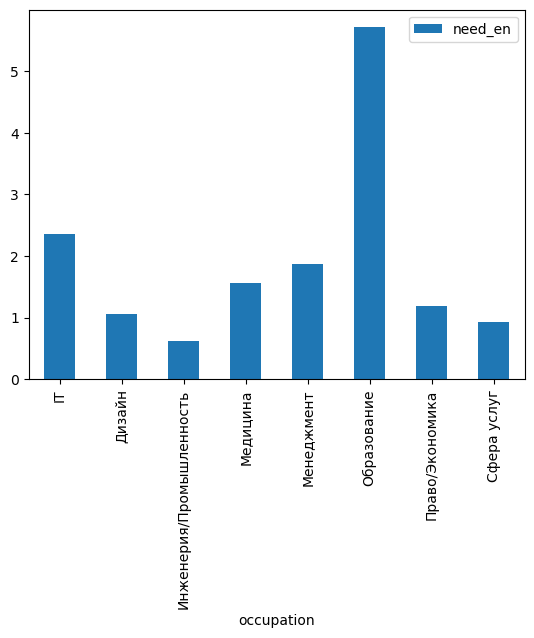

In [23]:
vacancy_inf = eng[['vacancy_id', 'occupation', 'need_en']].drop_duplicates()
(vacancy_inf[['occupation', 'need_en']].groupby('occupation').mean() * 100).plot.bar()

<Axes: xlabel='occupation'>

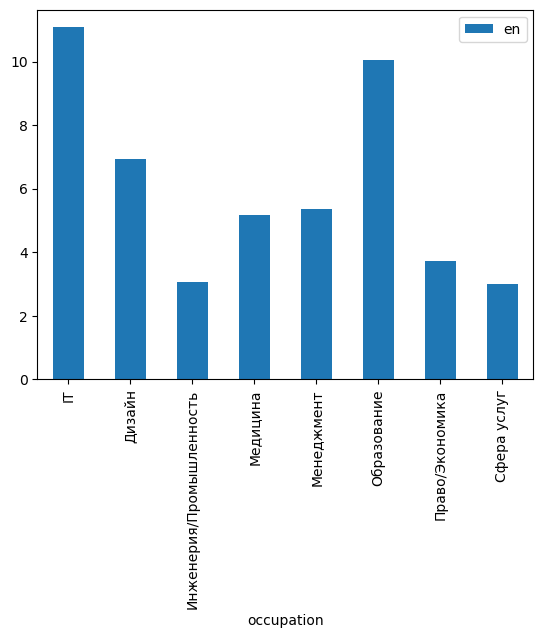

In [24]:
user_inf = eng[['resume_id', 'occupation', 'en']].drop_duplicates()
(user_inf[['occupation', 'en']].groupby('occupation').mean() * 100).plot.bar()

Теперь рассмотрим четыре сценария(NN - соискатель не знает англ и он не требуется, NY - соиск не знает, англ требуется, YN - соиск знает, не требуется, YY - соиск знает и требуется) в срезе каждой из сфер деятельности

In [25]:
eng = eng[eng.final_state != 'response']
eng.final_state = eng.final_state.map(lambda x: 1 if x == 'invitation' else 0)
eng['scenary'] = eng.apply((lambda x: ('Y' if x['en'] else 'N') + ('Y' if x['need_en'] else 'N')), 1)

In [26]:
gb = eng[['occupation', 'scenary', 'final_state']].groupby(['occupation', 'scenary']).mean()
gb

final_state
occupation               scenary             
IT                       NN          0.569047
                         NY          0.332268
                         YN          0.483267
                         YY          0.374302
Дизайн                   NN          0.701027
                         NY          0.406250
                         YN          0.516129
                         YY          0.000000
Инженерия/Промышленность NN          0.744266
                         NY          0.453333
                         YN          0.703297
                         YY          0.458333
Медицина                 NN          0.545495
                         NY          0.263158
                         YN          0.491525
                         YY          0.333333
Менеджмент               NN          0.672083
                         NY          0.466030
                         YN          0.633223
                         YY          0.528902
Образование              NN          0.675313
                         NY          0.500000
                         YN          0.644860
                         YY          0.516129
Право/Экономика          NN          0.553686
                         NY          0.357143
                         YN          0.497768
                         YY          0.348837
Сфера услуг              NN          0.775847
                         NY          0.613354
                         YN          0.697654
                         YY          0.611570

<Axes: xlabel='final_state', ylabel='occupation'>

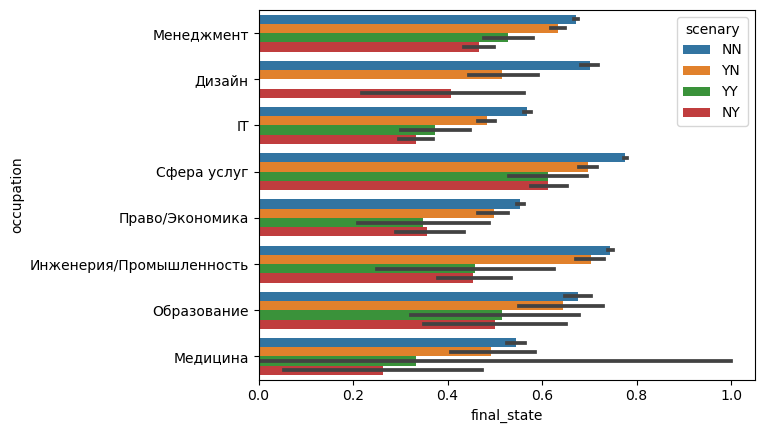

In [27]:
import seaborn as sns
sns.barplot(x='final_state', y='occupation', hue='scenary', data=eng, orient='h')

Заметим, что в сценариях NN, YN наибольший показатель приема в каждой из сфер. Незначительная разница между YY и NY во многих сферах может быть обусловлена тем, что у соискателя недостаточно высокий уровень английского языка, а также тем, что соискатель может не указывать английский в своих скиллах, но при подаче заявления а вакансию по умолчанию подразумевать то, что английский он знает.

В целом можно сделать предположение о том, что английский язык наиболее востребован в сферах образования, IT и менеджмента, что вполне ожидаемо, так как к последних двух сферах часто приходится работать с иностранцами, а в образовании очень популярна профессия именно учителя английского языка. Также можно предположить, что скорее всего на вакансию, где требуется английский будет сложнее устроиться, даже если вы его знаете. 

# Посмотрим на скиллы чуть подробнее

In [28]:
skills = []
for i in df.resume_skills_list:
    for j in i:
        if j:
            skills.append(j.lower())
skills = pd.Series(skills).value_counts()
list(skills[skills>5000].index)

['ответственность',
 'пользователь пк',
 'работа в команде',
 'организаторские навыки',
 'грамотная речь',
 'деловая переписка',
 'работа с большим объемом информации',
 'деловое общение',
 'обучаемость',
 'исполнительность',
 'работоспособность',
 'ведение переговоров',
 'телефонные переговоры',
 'управление персоналом',
 'коммуникабельность',
 'обучение персонала',
 'заключение договоров',
 'ms excel',
 'стрессоустойчивость',
 'умение работать в команде',
 'деловая коммуникация',
 'обучение и развитие',
 'ms word',
 'активные продажи',
 'английский язык',
 '1с: предприятие 8',
 'ms outlook',
 'навыки продаж',
 'руководство коллективом',
 'ms powerpoint',
 'водительское удостоверение категории b',
 'работа с оргтехникой',
 'поиск информации в интернет',
 'поиск и привлечение клиентов',
 'пунктуальность',
 'подбор персонала',
 'adobe photoshop',
 'управление продажами',
 'делопроизводство',
 'документооборот',
 'прямые продажи',
 'документальное сопровождение',
 'мотивация персонала',


In [29]:
soft_skills = ['ответственность', 'работа в команде', 'организаторские навыки', 'грамотная речь',
 'деловая переписка', 'работа с большим объемом информации', 'деловое общение', 'обучаемость',
 'исполнительность', 'работоспособность', 'ведение переговоров', 'телефонные переговоры',
 'управление персоналом', 'коммуникабельность', 'стрессоустойчивость', 'умение работать в команде',
 'деловая коммуникация', 'обучение и развитие', 'активные продажи', 'руководство коллективом',
 'пунктуальность', 'управление проектами', 'грамотность', 'навыки межличностного общения',
 'креативность', 'управленческие навыки', 'клиентоориентированность', 'умение работать в коллективе',
 'аналитическое мышление', 'управление командой', 'точность и внимательность к деталям',
 'целеустремленность', 'внимательность', 'копирайтинг', 'многозадачность', 'работа с возражениями',
 'навыки переговоров', 'навыки презентации', 'способность обучать других',
 'управление производственным персоналом', 'доброжелательность', 'урегулирование конфликтов',
 'планирование', 'быстрая обучаемость']
extra_skills=['пользователь пк', 'заключение договоров', 'ms excel', 'ms word', 'английский язык',
 'ms outlook', 'ms powerpoint', 'водительское удостоверение категории b', 'работа с оргтехникой',
 'проведение инвентаризаций', 'уверенный пользователь пк', 'договорная работа', 'составление договоров',
 'ведение отчетности', 'ведение групп в социальных сетях', 'работа с документами', 'работа с возражениями',
 'претензионная работа', 'навыки переговоров', 'офисная техника', 'обслуживание покупателей',
 'электронный документооборот', 'социальные сети', 'первичная документация', 'работа с жалобами клиентов',
 'навыки презентации', 'транспортная логистика', 'управление производственным персоналом',
 'оформление документации', 'продвижение в социальных группах', 'бумажный документооборот',]
# доп. скиллы - нельзя отнести ни к soft, ни к hard, но могут дать плюс в целом

In [30]:
def soft_count(l):
    res=0
    for i in l:
        if i and i in soft_skills:
            res+=1
    return res
skills_df = df.copy()
skills_df = skills_df[skills_df.vacancy_employment_type == 'full']
skills_df = skills_df[skills_df.final_state != 'response']
skills_df.final_state = skills_df.final_state.map(lambda x: 1 if x == 'invitation' else 0)

In [31]:
skills_df['soft_count'] = skills_df.resume_skills_list.map(soft_count)
skills_df = skills_df[skills_df.soft_count <= 10]

<Axes: xlabel='soft_count'>

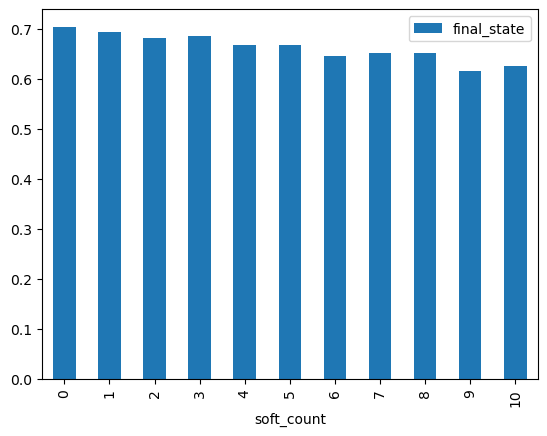

In [32]:
skills_df[['soft_count', 'final_state']].groupby('soft_count').mean().plot.bar()

In [33]:
# доля софтскиллов от всех
skills_df['soft_part'] = skills_df.soft_count / skills_df.resume_skills_list.map(lambda x: max(1, len(x)))

In [34]:
skills_df['soft_part'] = skills_df.soft_part.map(lambda x: round(x * 50) / 50)

<Axes: xlabel='soft_part'>

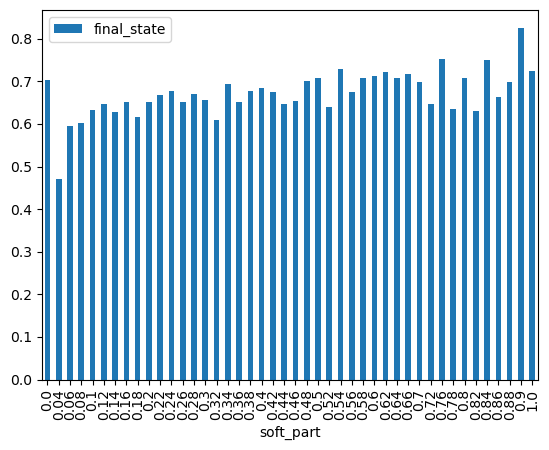

In [35]:
skills_df[['soft_part', 'final_state']].groupby('soft_part').mean().plot.bar()

# Посмотрим на гипотезу о наилучшем возрасте вхождения

In [36]:
ages = df.copy()
ages['age'] = ages.year_of_birth.apply(lambda x: 2023 - x)

In [37]:
ages.age.value_counts()

age
25     18498
23     17027
26     16837
36     16818
24     16775
       ...  
106        2
85         1
93         1
121        1
103        1
Name: count, Length: 75, dtype: int64

In [38]:
ages = ages[((ages.age <= 58) & (ages.gender == 'female')) 
            | ((ages.age <= 63) & (ages.gender == 'male'))]
ages = ages[ages.final_state != 'response']
ages.final_state = ages.final_state.map(lambda x: 1 if x == 'invitation' else 0)

In [39]:
ages = ages[~ages.profession.isna()]
ages['occupation'] = ages.profession.map(f)

In [40]:
def f_age(age):
    if age >= 14 and age < 18:
        return "14-17"
    if age >= 18 and age < 23:
        return "18-22"
    if age >= 23 and age < 29:
        return "23-28"
    if age >= 29 and age < 36:
        return "29-35"
    if age >= 36 and age < 46:
        return "36-45"
    if age >= 46 and age < 56:
        return "46-55"
    return "56-63"
ag = ['14-17', '18-22', '23-28', '29-35', '36-45', '46-55', '56-63']
ages['ages_group'] = ages.age.map(f_age)
ages.ages_group.value_counts()

ages_group
36-45    60899
29-35    60752
23-28    57881
18-22    35003
46-55    27766
56-63     5905
14-17     5434
Name: count, dtype: int64

In [41]:
import matplotlib.pyplot as plt

In [42]:
def plot(cat, min_age=14, max_age=63):
    print("Успешность при попытке попасть на собеседование.")
    print(f"Сфера: {cat}")
    curr = ages[(ages.occupation == cat) & (ages.age >= min_age) & (ages.age <= max_age)]
    gb = curr[['age', 'final_state']].groupby('age').mean()
    # gb.plot.bar()
    sns.barplot(x='age', y='final_state', hue='gender', data=curr)
def info(cat, min_age, max_age):
    curr = ages[ages.occupation == cat]
    print(f'Отличается ли успех группы {min_age}-{max_age} от среднего?')
    a = curr[(curr.age >= min_age) & (curr.age <= max_age)].final_state
    b = curr[(curr.age < min_age) | (curr.age > max_age)].final_state
    mean_a = a.mean()
    mean_b = b.mean()
    print(f"Показатели лучшей группы: {mean_a};\nПоказатели остальных: {mean_b}")
    alpha = mean_a - mean_b
    se = ((a.std() ** 2) / len(a) + (b.std() ** 2) / len(b)) ** 0.5
    print(f"Стандартная ошибка среднего: {se}")
    t = alpha / se
    print(f"t-критерий: {t}")
    print(f"Степени свободы: {len(a) + len(b) - 2}")
    if t < 1.6449:
        print("p-уровень значимость больше 0.1")
        print(f"Между успешностью группы {min_age}-{max_age} и ген. совокупности статистически значимых раличий нет")
    else:
        if t < 1.96:
            print("p-уровень значимость между 0.5 и 0.1")
        elif t < 2.5758:
            print("p-уровень значимость между 0.01 и 0.5")
        else:
            print("p-уровень значимости меньше 0.01")
        print(f"Различия между успешностью группы {min_age}-{max_age} и ген. совокупностью статистически значимые")

Успешность при попытке попасть на собеседование.
Сфера: Менеджмент


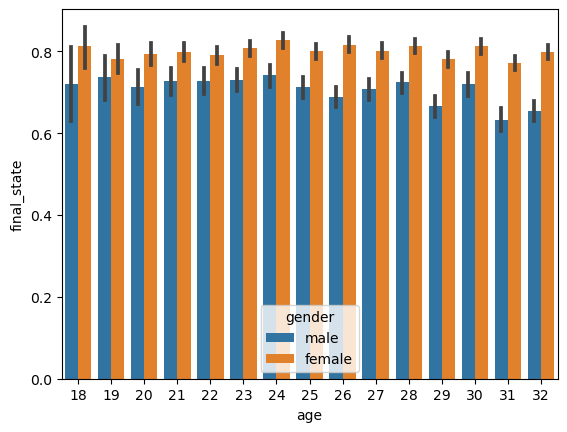

In [43]:
plot('Менеджмент', 18, 32)

In [44]:
info('Менеджмент', 18, 30)

Отличается ли успех группы 18-30 от среднего?
Показатели лучшей группы: 0.7695178238240205;
Показатели остальных: 0.6553093222055666
Стандартная ошибка среднего: 0.0032220553973812353
t-критерий: 35.445852889828714
Степени свободы: 79913
p-уровень значимости меньше 0.01
Различия между успешностью группы 18-30 и ген. совокупностью статистически значимые


Вполне ожидаемый результат, ищут молодых и креативных специалистов

Успешность при попытке попасть на собеседование.
Сфера: Сфера услуг


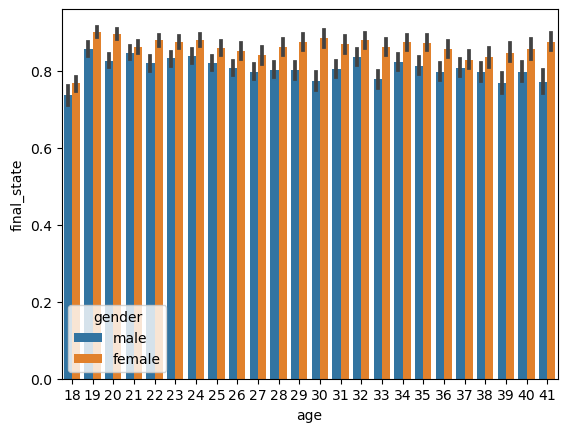

In [45]:
plot('Сфера услуг', 18, 41)

In [46]:
info('Сфера услуг', 19, 40)

Отличается ли успех группы 19-40 от среднего?
Показатели лучшей группы: 0.8397328881469115;
Показатели остальных: 0.6853343184336904
Стандартная ошибка среднего: 0.0032104748198094127
t-критерий: 48.09212916436667
Степени свободы: 84572
p-уровень значимости меньше 0.01
Различия между успешностью группы 19-40 и ген. совокупностью статистически значимые


Поскольку образование для данных специальностей не очень нужно, то ожидаемо, что возраст не будет иметь сильного значение. Единственное ограничение состоит в том, что люди старше 40 не такие быстрые и выносливые для работы в сфере обслуживания или на специальностях, в которых требуется физ.сила.

Успешность при попытке попасть на собеседование.
Сфера: IT


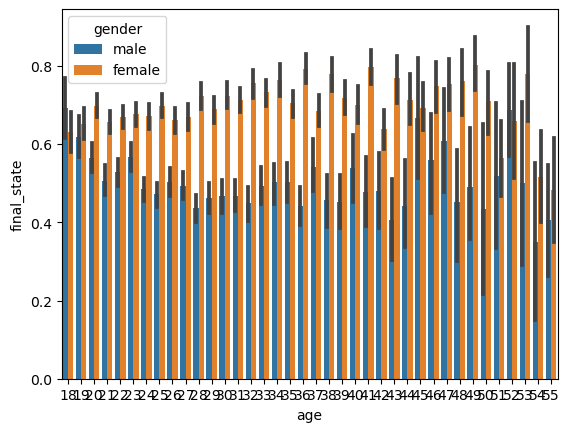

In [47]:
plot('IT', 18, 55)

Очень крутые показатели для группы 40-50. Возможно это обусловлено тем, что молодые специалисты менее квалифицированы(мы видим, что очень мало заявок исходит от людей старше 40, мы можем сделать предположение о том, что это люди, которые очень хорошо разбираются в теме, как минимум потому что люди, которые не умеют работать с компьютером, врятли бы смогли оставить заявку). Молодые же специалисты могут быть выпускниками средних учебных заведений, что нравится далеко не всем работодателям. Можно попытаться рассмотреть данную ситуация в срезе образования и отдельных специальностей. Очень крутые показатели у женского пола возрастов 20-40, при том, что кол-во заявок от мужчин и женщин примерно одинаково. Эту ситуацию также можно рассмотреть поподробнее.

In [54]:
ages[(ages.age > 43) & (ages.occupation == 'IT')]

,topic_id,topic_creation_date,initial_state,final_state,resume_id,resume_creation_date,profession,gender,year_of_birth,resume_region,...,vacancy_creation_date,vacancy_region,work_schedule.1,vacancy_employment_type,compensation_from,compensation_to,vacancy_skills_list,age,occupation,ages_group
31985,33969c69941,2023-08-11,response,1,2058240kt,2023-08-11,"Программист, разработчик",male,1976,Красноярский край,...,2023-08-07,Красноярский край,remote,part,35000.0,65000.0,"[деловая переписка, работа с большим объемом и...",47,IT,46-55
31989,33412747741263,2023-07-02,response,0,8bk0t814,2018-01-26,"Программист, разработчик",male,1972,Челябинская область,...,2023-06-14,Челябинская область,flexible,full,50000.0,NaN,"[svn, ios, intellij idea, git, java, android, ...",51,IT,46-55
32046,333044cc996,2023-07-04,response,1,260k64kk,2013-07-21,"Программист, разработчик",male,1971,Краснодарский край,...,2022-07-12,Нижегородская область,remote,full,160000.0,190000.0,"[1с: предприятие, 1с программирование, удаленн...",52,IT,46-55
32061,33341230616c,2023-07-05,response,1,260k64kk,2013-07-21,"Программист, разработчик",male,1971,Краснодарский край,...,2023-05-11,Москва,remote,full,180000.0,200000.0,"[умение работать в условиях многозадачности, 1...",52,IT,46-55
32084,3364129604779,2023-07-25,invitation,1,24b0kt68,2013-04-02,"Программист, разработчик",male,1978,Москва,...,2023-07-21,Москва,remote,full,150000.0,200000.0,"[docker, jquery, css, git, php, html5]",45,IT,36-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495438,33699699614412,2023-07-30,response,1,14614248,2011-07-22,"Оператор ПК, оператор базы данных",male,1971,Самарская область,...,2023-07-28,Красноярский край,remote,full,35000.0,NaN,"[деловая переписка, пользователь пк]",52,IT,46-55
495461,3412904309967,2023-06-06,response,1,160tb04tk,2022-01-17,"Оператор ПК, оператор базы данных",female,1974,Новосибирская область,...,2023-05-24,Новосибирская область,flexible,part,NaN,70000.0,"[работа в команде, грамотная речь]",49,IT,46-55
495472,33763412061412,2023-08-03,response,1,18t50k8b,2012-05-15,"Оператор ПК, оператор базы данных",female,1979,Ленинградская область,...,2023-08-03,Санкт-Петербург,remote,part,NaN,370000.0,"[консультирование клиентов по телефону, работа...",44,IT,36-45
495473,3412933969c97,2023-06-08,invitation,1,201850065,2023-06-04,"Оператор ПК, оператор базы данных",female,1970,Санкт-Петербург,...,2023-05-26,Санкт-Петербург,full_day,full,30000.0,NaN,"[ведение архива, проектная деятельность, бумаж...",53,IT,46-55


Успешность при попытке попасть на собеседование.
Сфера: Инженерия/Промышленность


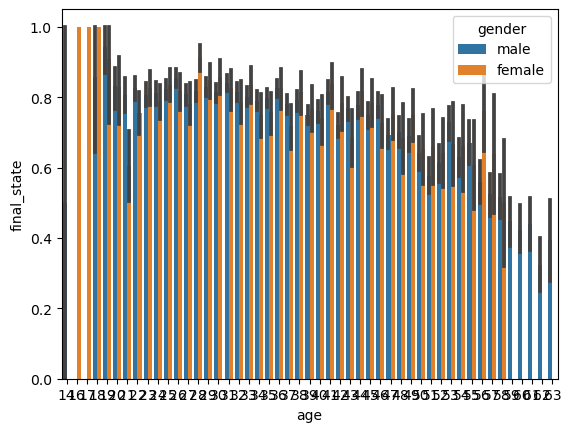

In [56]:
plot('Инженерия/Промышленность')

видим явную склонность к возрасту 20-40. Высокие показатели для несовершеннолетних мб из-за маленького числа заявок.

In [61]:
ages[(ages.occupation=='Инженерия/Промышленность') & (ages.age <= 18)]

,topic_id,topic_creation_date,initial_state,final_state,resume_id,resume_creation_date,profession,gender,year_of_birth,resume_region,...,vacancy_creation_date,vacancy_region,work_schedule.1,vacancy_employment_type,compensation_from,compensation_to,vacancy_skills_list,age,occupation,ages_group
76854,33cc96c73412c,2023-07-20,invitation,1,202l8241,2023-06-16,Сварщик,male,2005,Томская область,...,2023-07-05,Томская область,full_day,full,50000.0,50000.0,"[способность обучать других, сварочные работы,...",18,Инженерия/Промышленность,18-22
93583,3379397041,2023-08-05,response,0,20l55tf,2023-08-05,Сварщик,male,2009,Тверская область,...,2023-07-28,Тверская область,shift,full,70000.0,NaN,"[чтение чертежей, владение полуавтоматической ...",14,Инженерия/Промышленность,14-17
93595,3379396977,2023-08-05,response,1,20l55tf,2023-08-05,Сварщик,male,2009,Тверская область,...,2023-07-17,Тверская область,full_day,full,70000.0,NaN,[None],14,Инженерия/Промышленность,14-17
93648,339630c96697,2023-08-08,invitation,1,2055tk45k,2023-08-07,Сварщик,male,2005,Ростовская область,...,2023-07-20,Ростовская область,full_day,full,45000.0,NaN,[None],18,Инженерия/Промышленность,18-22
93861,33696496711,2023-07-29,response,1,20bk4tt82,2023-07-06,Сварщик,male,2005,Астраханская область,...,2023-07-27,Астраханская область,shift,full,30800.0,0.0,"[деловое общение, активные продажи, навыки про...",18,Инженерия/Промышленность,18-22
94039,33412c4c96613,2023-06-30,invitation,1,20b2b804k,2023-06-28,Сварщик,male,2005,Воронежская область,...,2023-06-15,Воронежская область,full_day,full,45000.0,0.0,"[умение работать с клиентами, уверенный пользо...",18,Инженерия/Промышленность,18-22
94256,33903669669,2023-08-12,response,0,1tk2t4525,2023-02-28,Сварщик,male,2005,Московская область,...,2023-08-08,Московская область,full_day,full,80000.0,150000.0,"[монтаж оборудования, сварочные работы, монтаж...",18,Инженерия/Промышленность,18-22
99875,3396b412c317,2023-08-08,invitation,1,1tt58k6l,2023-04-15,Сварщик,male,2005,Тверская область,...,2023-07-13,Тверская область,shift,full,55000.0,NaN,"[усердность, опрятный внешний вид, сварка, раб...",18,Инженерия/Промышленность,18-22
174541,b14129641269641296,2023-08-27,response,1,1t856188k,2023-03-26,Оператор производственной линии,female,2007,Санкт-Петербург,...,2023-08-27,Санкт-Петербург,shift,part,94000.0,229000.0,[None],16,Инженерия/Промышленность,14-17
174551,3301c970412c,2023-06-14,response,1,1t856188k,2023-03-26,Оператор производственной линии,female,2007,Санкт-Петербург,...,2023-05-03,Санкт-Петербург,flexible,full,34000.0,50000.0,[None],16,Инженерия/Промышленность,14-17


Успешность при попытке попасть на собеседование.
Сфера: Инженерия/Промышленность


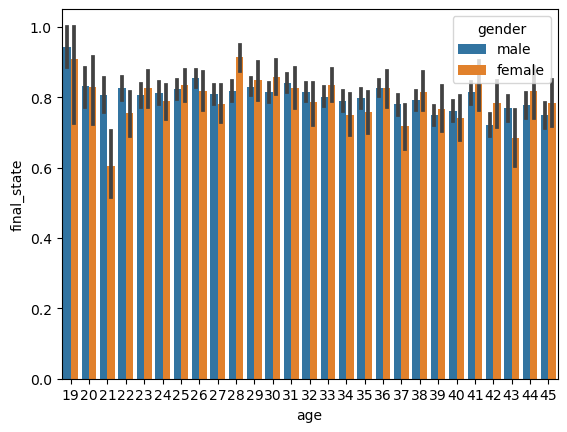

In [62]:
plot('Инженерия/Промышленность', 19, 45)

In [63]:
info('Инженерия/Промышленность', 26, 37)

Отличается ли успех группы 26-37 от среднего?
Показатели лучшей группы: 0.8129566488066244;
Показатели остальных: 0.726220257141195
Стандартная ошибка среднего: 0.004890093623892967
t-критерий: 17.73716381249553
Степени свободы: 29505
p-уровень значимости меньше 0.01
Различия между успешностью группы 26-37 и ген. совокупностью статистически значимые


Ожидаемые результаты для сферы, где часто требуется физ.сила, а также для опасных и вредных для здоровья профессий.

Успешность при попытке попасть на собеседование.
Сфера: Право/Экономика


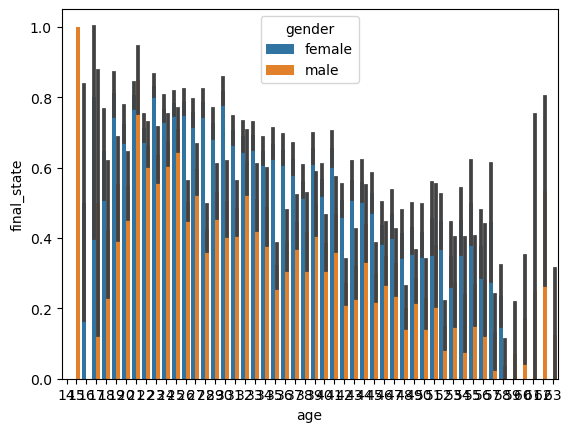

In [67]:
plot('Право/Экономика')

Успешность при попытке попасть на собеседование.
Сфера: Право/Экономика


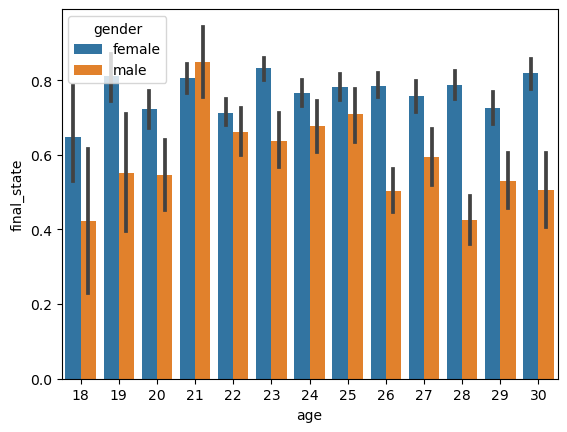

In [65]:
plot('Право/Экономика', 18, 30)

Успешность при попытке попасть на собеседование.
Сфера: Право/Экономика


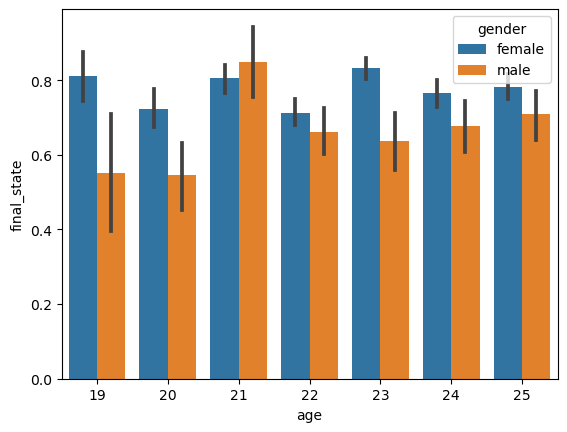

In [66]:
plot('Право/Экономика', 19, 25)

In [69]:
ages[(ages.occupation=='Право/Экономика') & (ages.gender=='male')]

,topic_id,topic_creation_date,initial_state,final_state,resume_id,resume_creation_date,profession,gender,year_of_birth,resume_region,...,vacancy_creation_date,vacancy_region,work_schedule.1,vacancy_employment_type,compensation_from,compensation_to,vacancy_skills_list,age,occupation,ages_group
46313,3364796c740,2023-07-26,response,0,15585185b,2021-09-23,"Делопроизводитель, архивариус",male,1995,Москва,...,2023-07-26,Москва,full_day,full,NaN,60000.0,[None],28,Право/Экономика,23-28
46330,33412c9412741233,2023-06-30,response,1,1611tb8b6,2022-01-21,"Делопроизводитель, архивариус",male,1991,Московская область,...,2023-06-28,Московская область,full_day,full,25000.0,0.0,"[электронный архив, уверенный пользователь пк,...",32,Право/Экономика,29-35
46402,33964120412412303,2023-08-07,response,0,15585185b,2021-09-23,"Делопроизводитель, архивариус",male,1995,Москва,...,2023-07-21,Москва,full_day,full,55000.0,55000.0,"[внутренняя документация, регистрация документ...",28,Право/Экономика,23-28
46522,33960314129c412,2023-08-06,response,0,188486110,2022-09-05,"Делопроизводитель, архивариус",male,1992,Санкт-Петербург,...,2023-08-03,Санкт-Петербург,full_day,full,45000.0,0.0,"[аналитический склад ума, уверенный пользовате...",31,Право/Экономика,29-35
46525,336964696930,2023-07-28,response,0,188486110,2022-09-05,"Делопроизводитель, архивариус",male,1992,Санкт-Петербург,...,2023-05-31,Санкт-Петербург,full_day,full,45000.0,NaN,[None],31,Право/Экономика,29-35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484714,341296319cc6412,2023-06-01,response,0,fg506b8,2019-08-22,Юрисконсульт,male,1961,Санкт-Петербург,...,2023-05-31,Санкт-Петербург,full_day,full,80000.0,NaN,"[взаимодействие с контрольными органами, юрист...",62,Право/Экономика,56-63
484720,341296649641211,2023-06-04,response,0,445081k0,2015-08-27,Юрисконсульт,male,1982,Московская область,...,2023-06-02,Московская область,full_day,full,120000.0,120000.0,"[офисная техника, согласование договоров, доку...",41,Право/Экономика,36-45
484725,33963b4126696,2023-08-08,response,1,20201b8tk,2023-06-06,Юрисконсульт,male,1986,Москва,...,2023-08-07,Москва,remote,part,50000.0,90000.0,"[консультирование клиентов по телефону, поиск ...",37,Право/Экономика,36-45
484737,3341200cc166,2023-06-27,response,0,20201b8tk,2023-06-06,Юрисконсульт,male,1986,Москва,...,2023-06-06,Москва,full_day,full,85000.0,NaN,"[отчетность, желание расти и развиваться, жела...",37,Право/Экономика,36-45


Слишком большой разброс между женщинами и мужчинами, однако женщин подающих заявки в ~3.5 раза больше, чем мужчин. Также не совсем понятно почему молодых спецов приглашают намного чаще, чем более старших.

Успешность при попытке попасть на собеседование.
Сфера: Дизайн


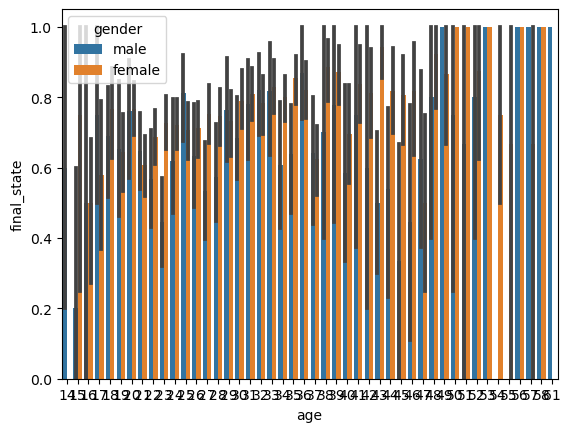

In [70]:
plot('Дизайн')

Поскольку записей о сфере оч мало, то нежелательно по ним выводы делать, а так можно заметить, что в творческих профессиях не очень важен возраст, а также что женщин приглашают на собеседование чаще.

Успешность при попытке попасть на собеседование.
Сфера: Медицина


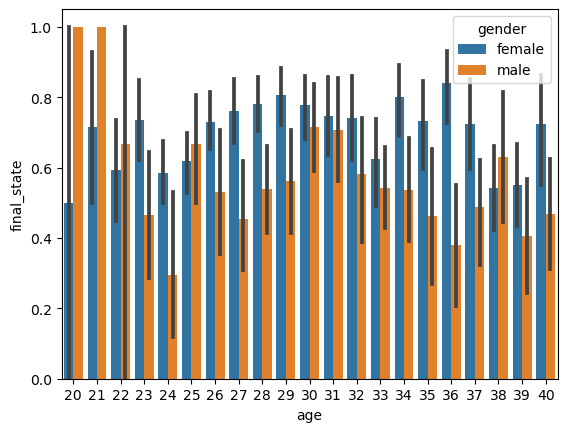

In [75]:
plot('Медицина', 20, 40)

In [76]:
info('Медицина', 25, 34)

Отличается ли успех группы 25-34 от среднего?
Показатели лучшей группы: 0.6808675445391169;
Показатели остальных: 0.5261282660332541
Стандартная ошибка среднего: 0.017792642055378605
t-критерий: 8.696812874908932
Степени свободы: 2973
p-уровень значимости меньше 0.01
Различия между успешностью группы 25-34 и ген. совокупностью статистически значимые


Вполне ожидаемо, наиболее востребованными специалистами являются не очень старые, но опытные специалисты

Успешность при попытке попасть на собеседование.
Сфера: Образование


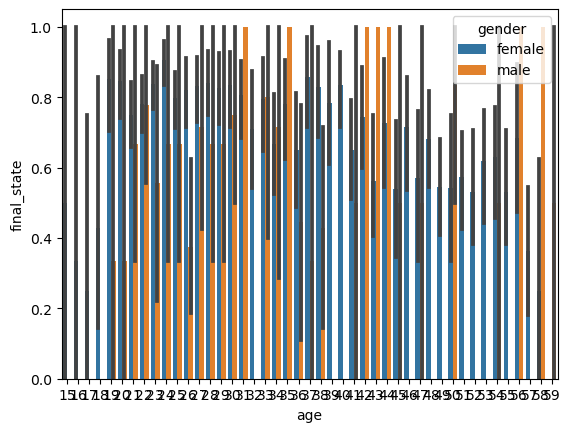

In [77]:
plot('Образование')

Мало инфы, чтобы что-то говорить, на первый взгляд можно сказать, что особых различий нет

In [63]:
ages.occupation.value_counts()

occupation
Сфера услуг                 84574
Менеджмент                  79915
IT                          32036
Инженерия/Промышленность    29507
Право/Экономика             19249
Дизайн                       3523
Медицина                     2975
Образование                  1861
Name: count, dtype: int64

# Смотрим гипотезу о совместимости регионов

In [90]:
regs = df.copy()
regs.resume_region.value_counts()

resume_region
Москва                  149223
Санкт-Петербург          60572
Московская область       33711
Краснодарский край       20212
Республика Татарстан     15365
                         ...  
Еврейская АО                40
Запорожская область         33
Ненецкий АО                  8
Херсонская область           5
Чукотский АО                 4
Name: count, Length: 88, dtype: int64

Идеи две: любо записывать регионы соседи, либо смотреть расстояния между региональными центрами. Пока рассмотрим только случаи совпадения

In [91]:
regs['match'] = regs.apply(lambda x: x['resume_region'] == x['vacancy_region'], 1)
regs = regs[regs.final_state != 'response']
regs['final_state'] = regs.final_state.map(lambda x: 1 if x == 'invitation' else 0)

<Axes: xlabel='match'>

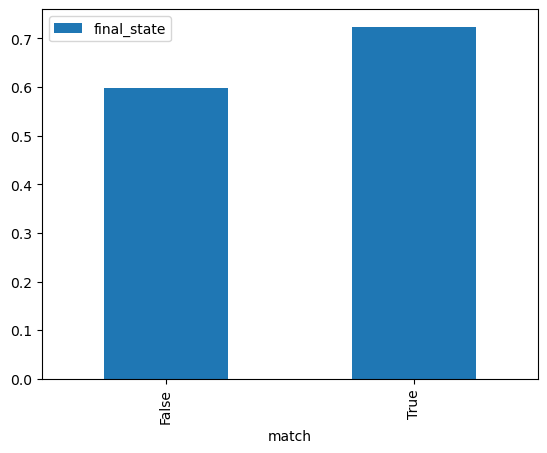

In [103]:
regs_offline = regs[regs['work_schedule.1']!='remote']
offline_inf = regs_offline[['match', 'final_state']]
offline_inf.groupby('match').mean().plot.bar()

In [108]:
a = offline_inf[offline_inf.match].final_state
b = offline_inf[~offline_inf.match].final_state
mean_a = a.mean()
mean_b = b.mean()
alpha = mean_a - mean_b
mean_a, mean_b

(0.7239030119976508, 0.597870064642143)

In [109]:
se = ((a.std() ** 2) / len(a) + (b.std() ** 2) / len(b)) ** 0.5

In [110]:
t = alpha / se
print(f"t-критерий: {t}; степени свободы: {len(a) + len(b) - 2}")

t-критерий: 35.93720124891725; степени свободы: 200286


<Axes: xlabel='match'>

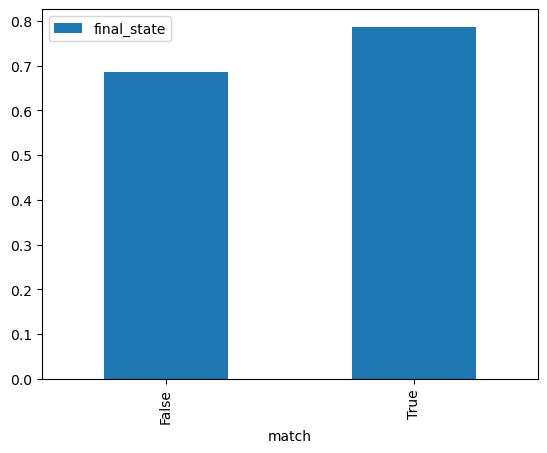

In [111]:
regs_online = regs[regs['work_schedule.1']=='remote']
online_inf = regs_online[['match', 'final_state']]
online_inf.groupby('match').mean().plot.bar()

In [116]:
a = online_inf[online_inf.match].final_state
b = online_inf[~online_inf.match].final_state
mean_a = a.mean()
mean_b = b.mean()
alpha = mean_a - mean_b
mean_a, mean_b

(0.7868037258321892, 0.685686819789199)

In [117]:
se = ((a.std() ** 2) / len(a) + (b.std() ** 2) / len(b)) ** 0.5
se

0.0036911739722726915

In [118]:
t = alpha / se
print(f"t-критерий: {t}; степени свободы: {len(a) + len(b) - 2}")

t-критерий: 27.39424009883; степени свободы: 56072


Даже на удаленке чаще зовут тех, кто в одном и том же регионе с ними, мб связываться удобнее и все такое